# py2cytoscape 0.6.0 New Features

By Keiichiro Ono (kono ucsd edu)

Updated on 7/15/2016

## New in 0.6.0
* Session Saving and loading API
* Preset layout utility method
* Numpy array support
* Bug fixes

In [1]:
# Tested on:
!python --version

Python 3.5.1 :: Anaconda 4.0.0 (x86_64)


In [2]:
# Boilerplate: Import required packages
from py2cytoscape.data.cyrest_client import CyRestClient
from py2cytoscape.data.util_network import NetworkUtil as util
from py2cytoscape.data.style import StyleUtil as s_util
import py2cytoscape.cytoscapejs as renderer
from IPython.display import Image
import networkx as nx
from networkx.drawing import nx_pydot as pyd
import igraph as ig
import numpy as np
import pandas as pd

<IPython.core.display.Javascript object>

## Create client and clean up current workspace

In [3]:
# Create Client
cy = CyRestClient()
# Clear current session
cy.session.delete()

## New: Create network from NumPy (*ndarray*)

Currently supporting **undirected** graphs only.

## Supported data types

### 1. Binary matrix (default)
If the array contains only 0s and 1s, it will be handles as an ***undirected, unweighted graph***.

#### How to create graph from ndarray
Only upper half of the array will be used for graph generation.  For example this binary array:

```
0, 1, 1, 0
0, 0, 1, 0
0, 0, 0, 1
0, 0, 0, 0
```

will create the graph like this:

In [4]:
matrix1 = np.array([
    [0, 1, 1, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [0, 0, 0, 0]])

net1 = cy.network.create_from_ndarray(matrix1, name='binary sample')
cy.layout.apply(network=net1)
cy.layout.fit(network=net1)

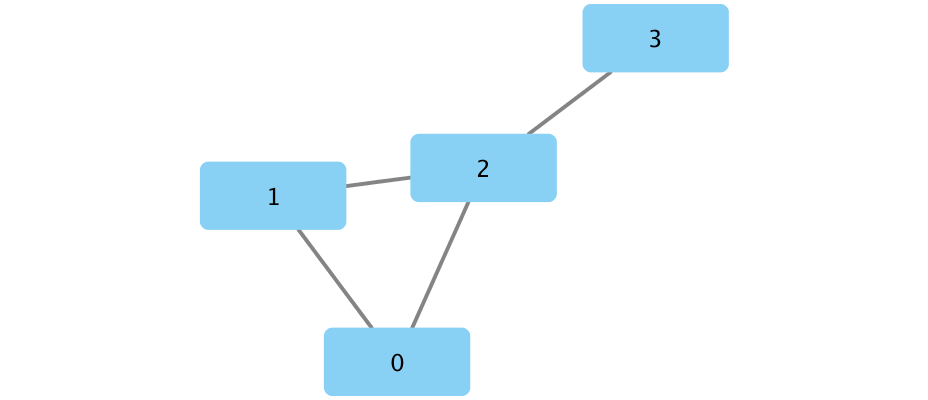

In [5]:
Image(net1.get_png(height=400))

### 2. Weights
You can also create weighted egdes.  If the matrix contains floating point numbers, it will be handles as an ***undirected, weighted graph***.  In this case, ***numpy.nan*** represents **"edge does not exists."**.  Again, only upper half of matrix will be used.  

In [6]:
# Create a random graph
matrix_size = 10
weighted = np.empty((matrix_size,matrix_size,))
weighted[:] = np.NAN

row_idx = 0
for row in weighted:
    idx = row_idx
    while idx < matrix_size:
        if idx != row_idx and np.random.randint(2):
            weighted[row_idx][idx] = np.random.randn()
        idx +=1
    row_idx += 1

# for printing
df = pd.DataFrame(weighted)
df.head(10)

,0,1,2,3,4,5,6,7,8,9
0,NaN,NaN,0.024421,NaN,0.406917,NaN,1.482448,1.203733,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,-0.028704,-0.551955,0.537825,-0.052128,-0.028828
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.382637,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,-0.647074,NaN,NaN,0.993722
4,NaN,NaN,NaN,NaN,NaN,-0.733767,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,0.541588,-0.102909,NaN,-0.526198
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.212615,NaN,-0.355173
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.043718
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Random Network with weighted edges
Edge weights are mapped to edge width

In [7]:
weight_min = weighted.min() 
weight_max = weighted.max() 
 
net2 = cy.network.create_from_ndarray(weighted, name='weighted sample', weighted=True)
cy.layout.apply(network=net2, name="circular")
cy.layout.fit(network=net2)

# Styling
style_s2 = cy.style.create('Sample2')

defaults = {    
    'NODE_SIZE': 12,
    'NODE_BORDER_WIDTH': 2,
    'NODE_LABEL_FONT_SIZE': 14,
    'NODE_LABEL_COLOR': '#555555',
    'EDGE_TRANSPARENCY': 100,
    'EDGE_STROKE_UNSELECTED_PAINT': '#999999',
    'NETWORK_BACKGROUND_PAINT': '#FFFFFF'
}
style_s2.update_defaults(defaults)
score_to_width = s_util.create_slope(min=weight_min, max=weight_max, values=(1, 8))
style_s2.create_continuous_mapping(column='weight', vp='EDGE_WIDTH', col_type='Double', points=score_to_width)
cy.style.apply(style=style_s2, network=net2)

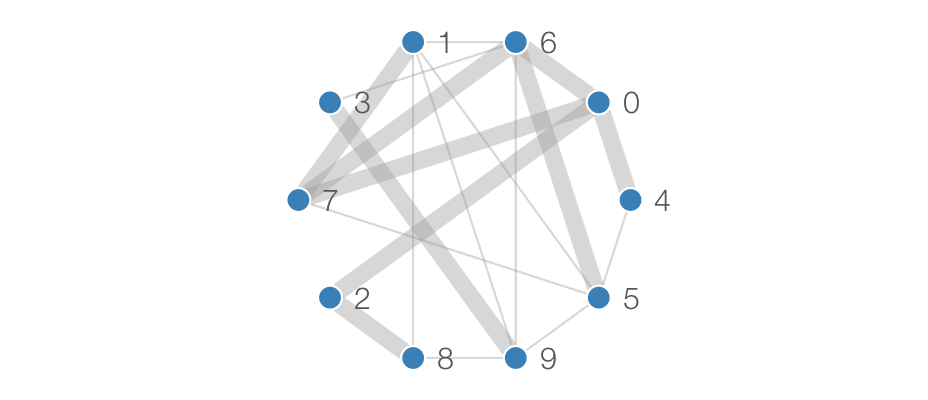

In [8]:
Image(net2.get_png(height=400))

### Some more examples

In [9]:
d1 = np.random.randint(2, size=(10, 10))
dn1 = cy.network.create_from_ndarray(d1, name="Random")
cy.layout.apply(network=dn1, name="kamada-kawai")
style_s3 = cy.style.create('Sample3')
cy.style.apply(style=style_s3, network=dn1)

In [10]:
cy.network.create_from_ndarray(d1, name="Random")
cy.network.create_from_ndarray(d2, name="Complete")

NameError: name 'd2' is not defined

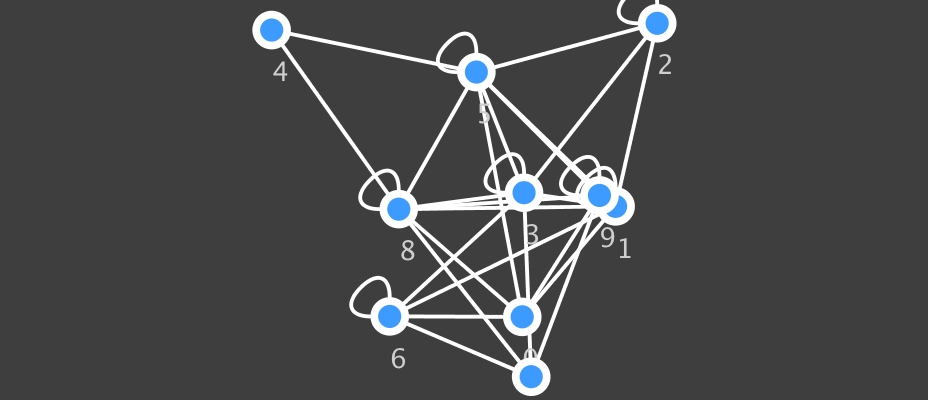

In [11]:
Image(dn1.get_png(height=400))

In [12]:
d2 = np.ones((100,100))
dn2 = cy.network.create_from_ndarray(d2, name="Complete")
cy.layout.apply(network=dn2, name="circular")
cy.layout.fit(network=dn2)

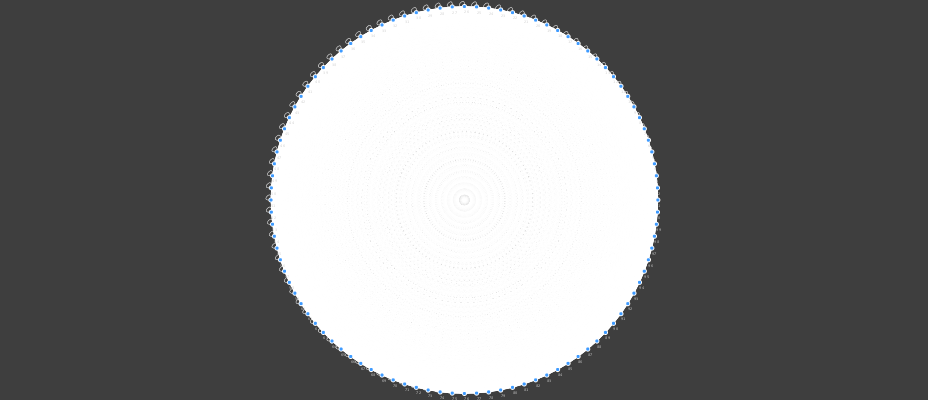

In [13]:
Image(dn2.get_png(height=400))

## New: Layout nodes manually
You can pass (x,y) locations directly to the network view

### Creating networks with NetworkX and igraph

In [14]:
# Create with NetworkX (Scale-Free graph w/100 nodes)
g = nx.powerlaw_cluster_graph(50,4, 0.5)

# Calculate some graph statistics
deg = nx.degree(g)
btw = nx.betweenness_centrality(g)
nx.set_node_attributes(g, 'degree', deg)
nx.set_node_attributes(g, 'betweenness', btw)

# Create with igraph (Tree w/500 nodes)
g2 = ig.Graph.Tree(400, 5)

## Use 3rd party layout algorithms which does not exists in Cytoscape

In [15]:
# Graphviz Layout
n_layout = pyd.graphviz_layout(g, prog='dot')

# Reingold-Tilford tree layout with a polar coordinate post-transformation
i_layout = g2.layout("rt_circular")
i_layout.scale(200)

In [16]:
g_cy = cy.network.create_from_networkx(g)
nodes = g_cy.get_nodes()
idmap = util.name2suid(g_cy)
locations =[]

for k in n_layout.keys():
    v = n_layout[k]
    locations.append([int(idmap[k]), v[0] , v[1]])

cy.layout.apply_from_presets(g_cy, positions=locations)
cy.layout.bundle_edge(g_cy)
my_style = cy.style.create('Marquee')
cy.style.apply(style=my_style, network=g_cy)

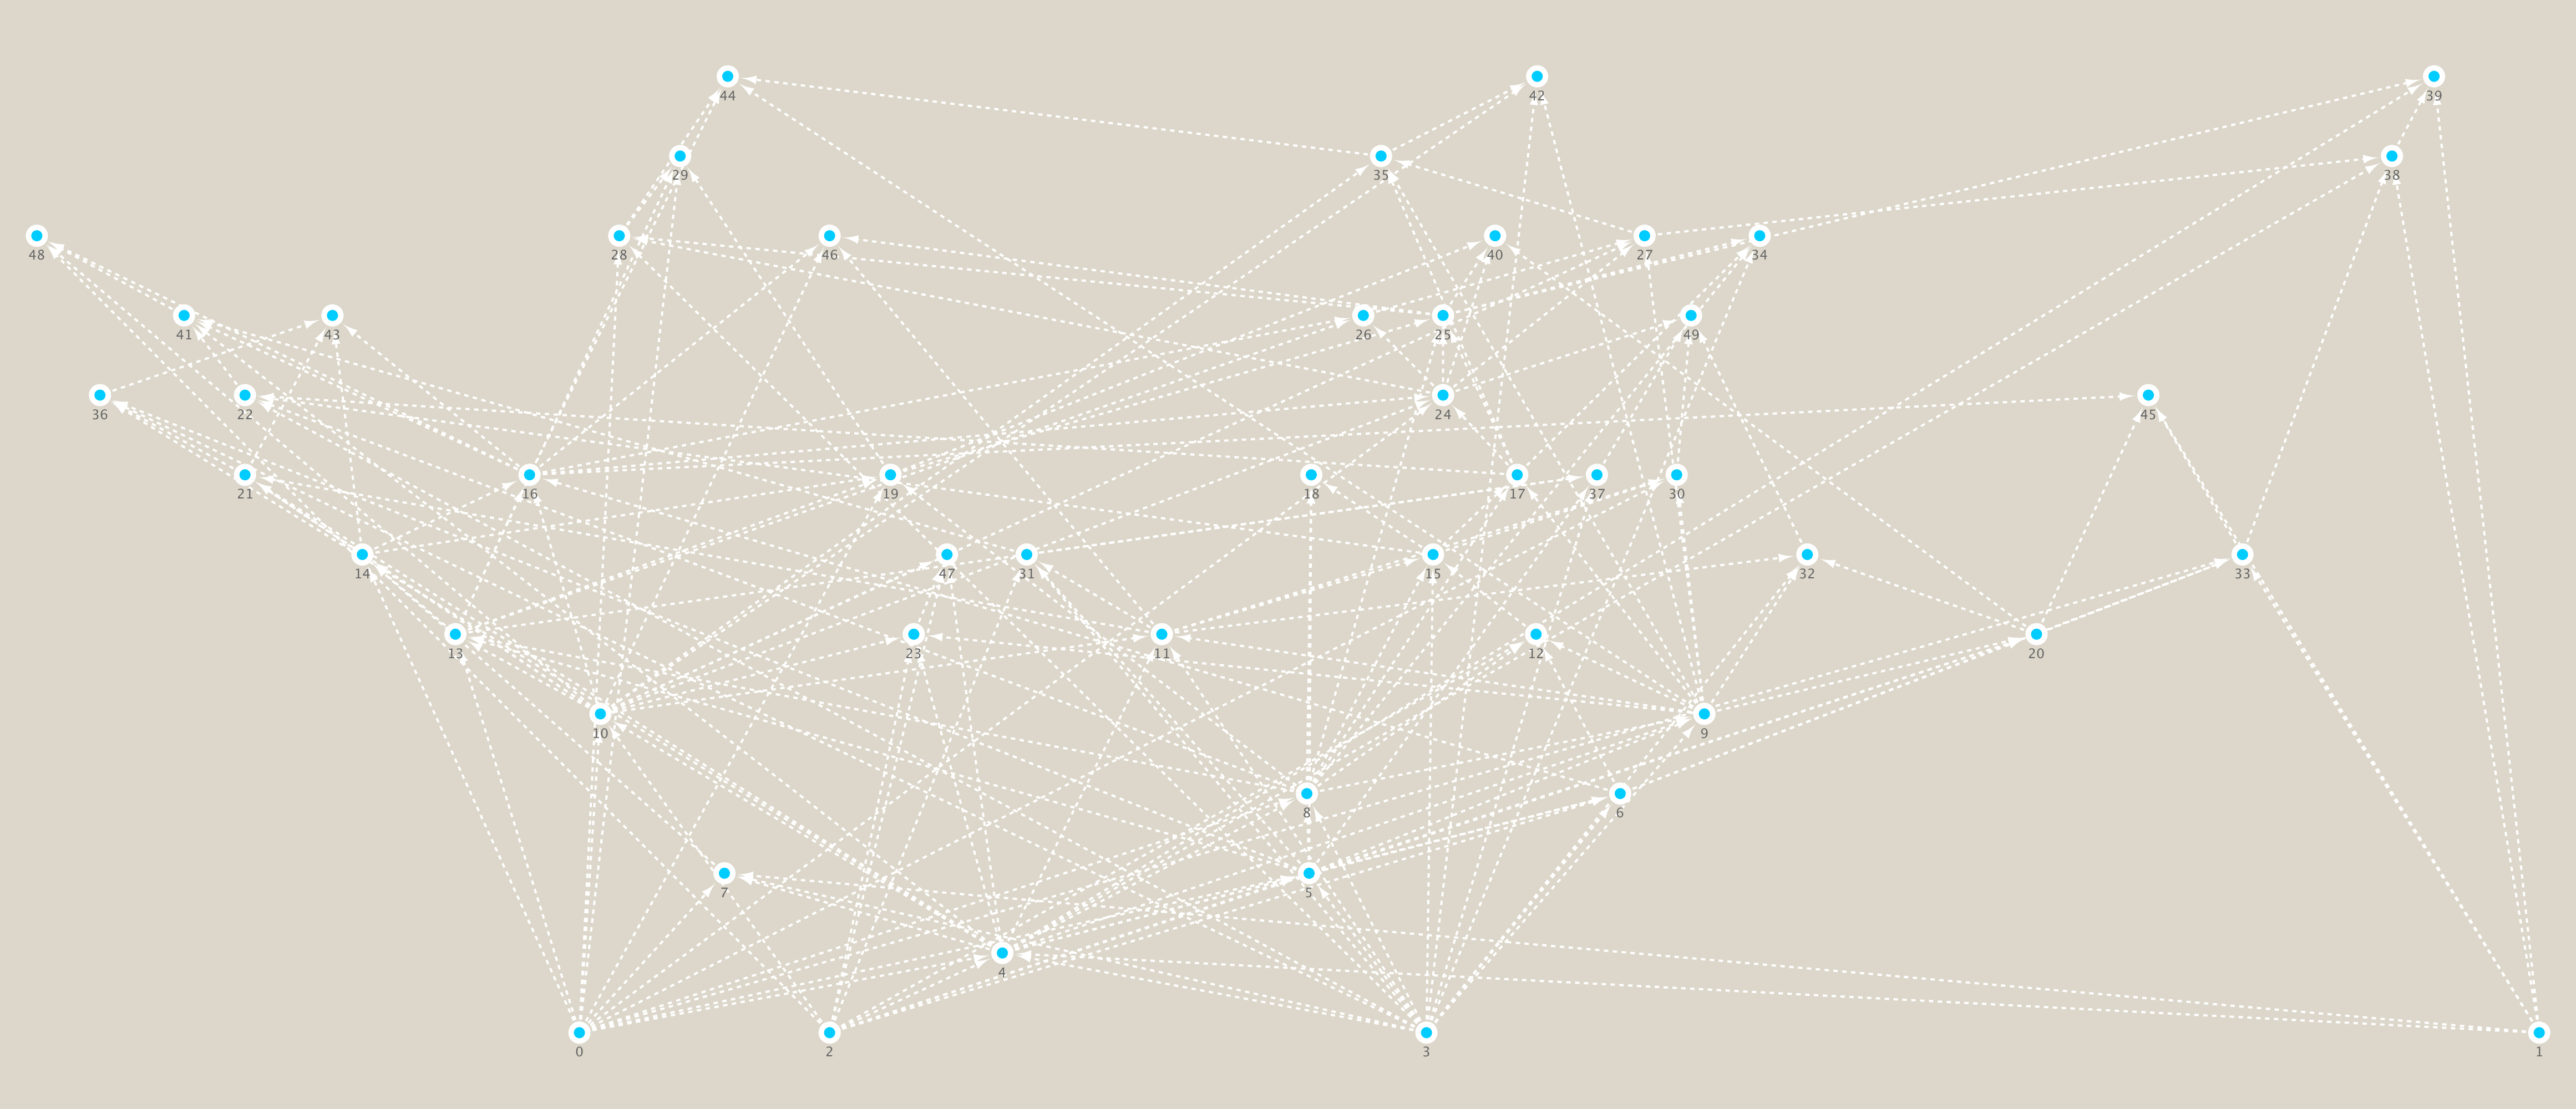

In [17]:
Image(g_cy.get_png(height=2000))

In [18]:
style_for_widget = cy.style.get(my_style.get_name(), data_format='cytoscapejs')
renderer.render(g_cy.get_first_view(), style=style_for_widget['style'], background='radial-gradient(#EEEEEE 10%, #BBBBBB 105%)')

In [19]:
g2_cy = cy.network.create_from_igraph(g2)
nodes = g2_cy.get_nodes()
idmap = util.name2suid(g2_cy)
locations =[]
for i, l in enumerate(i_layout):
    locations.append([int(idmap[i]), l[0] , l[1] ])

cy.layout.apply_from_presets(g2_cy, positions=locations)
cy.style.apply(style=style_s3, network=g2_cy)
cy.layout.bundle_edge(g2_cy)

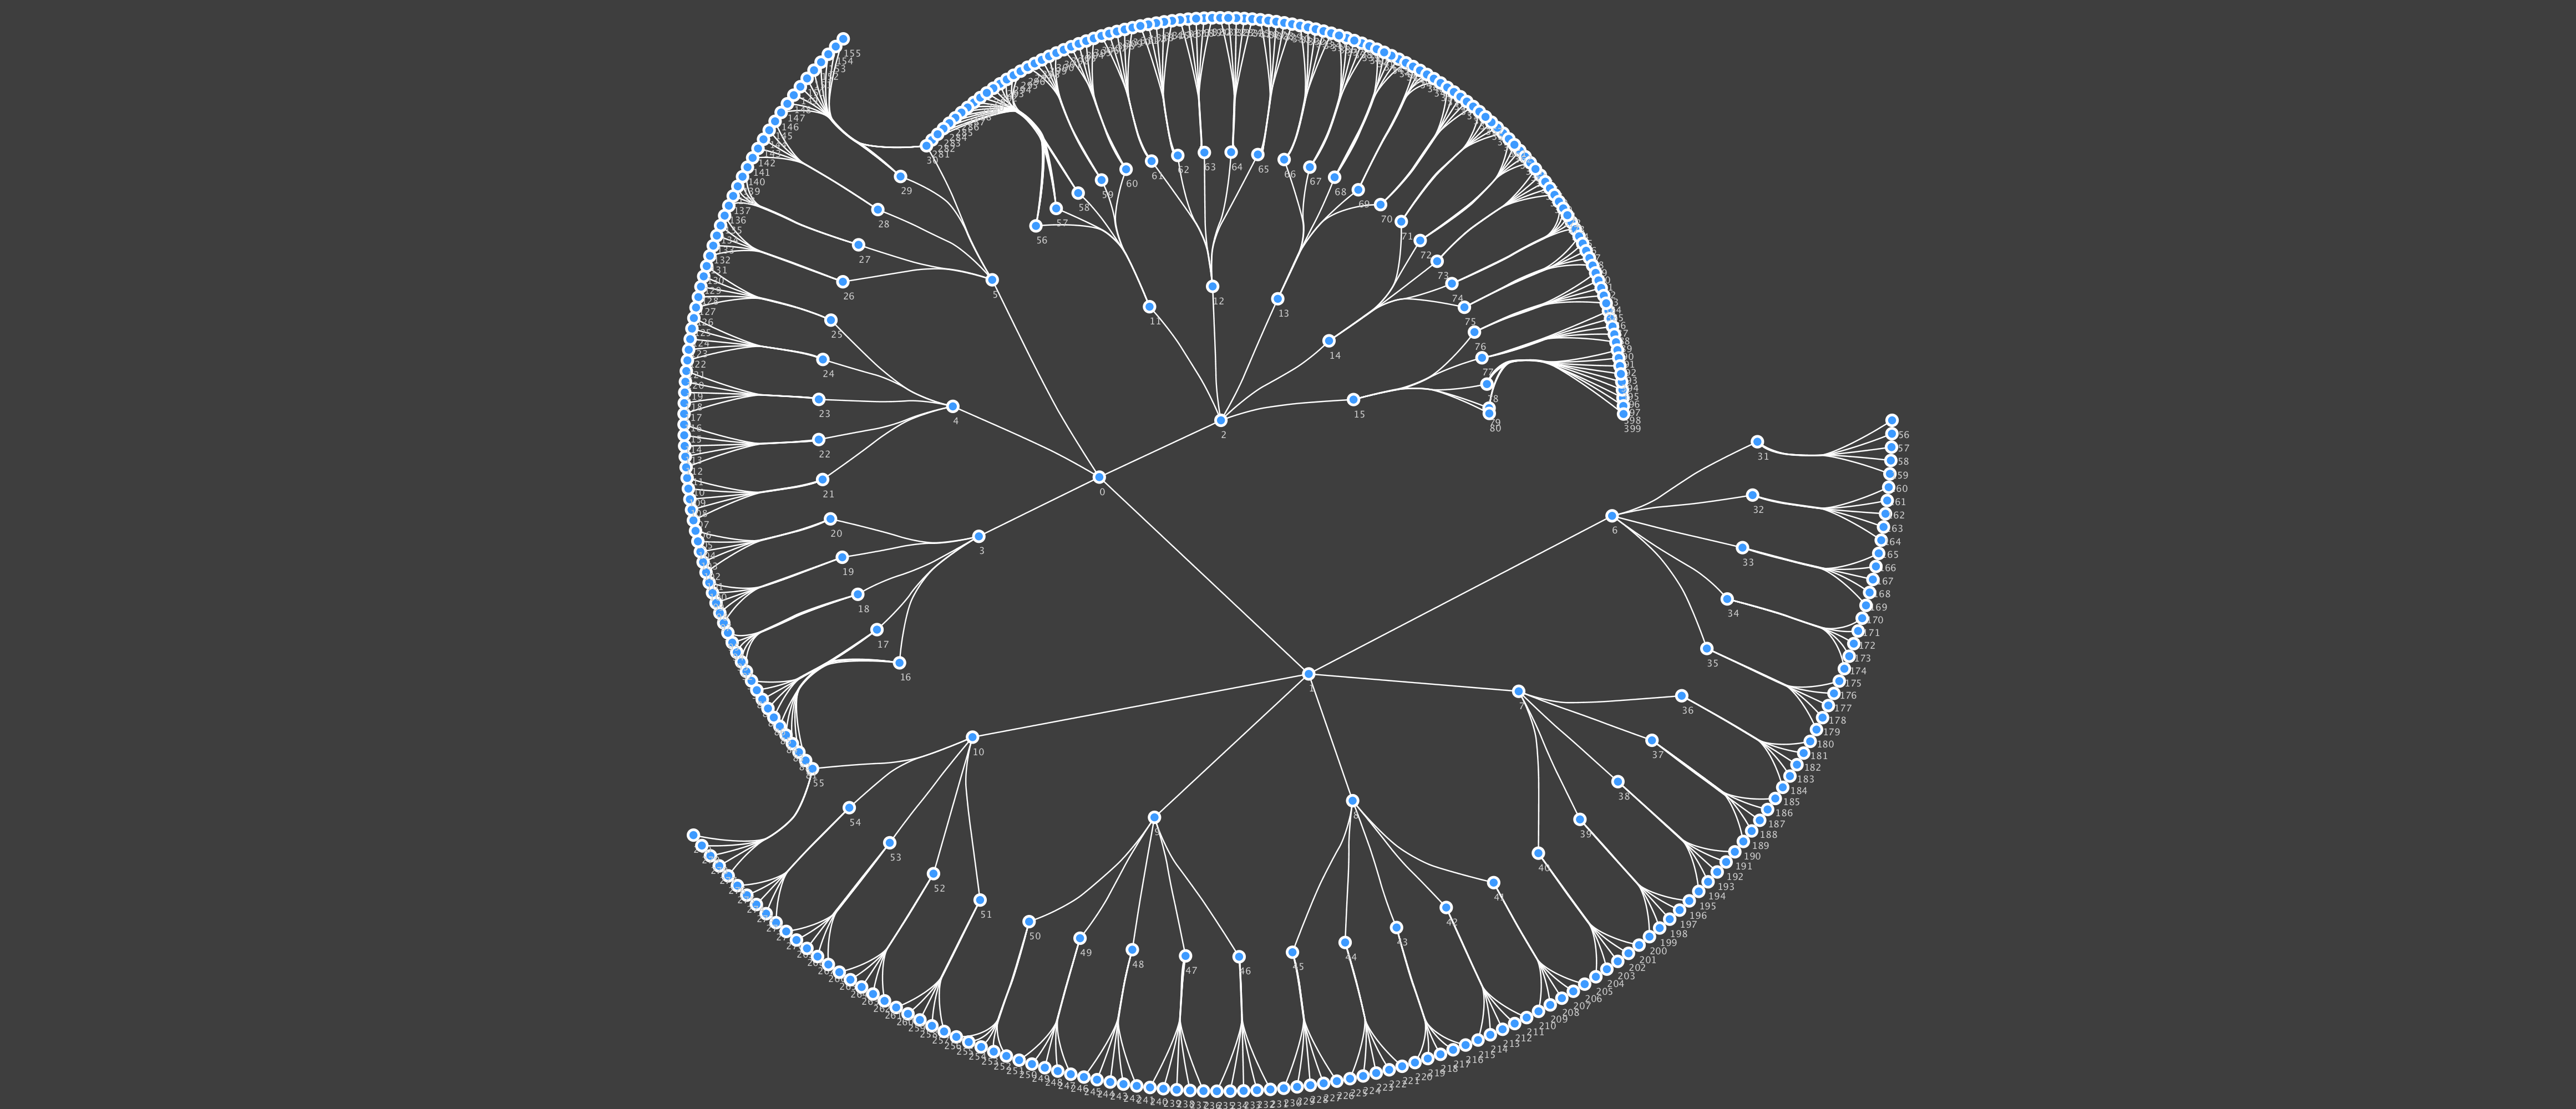

In [20]:
Image(g2_cy.get_png(height=2000))

In [21]:
renderer.render(g2_cy.get_first_view(), background='radial-gradient(#FFFFFF 10%, #999999 105%)')

## Saving/loading sessions

In [22]:
# Save the session
# cy.session.save(file_name='/Users/path_to_your_dir/sample1.cys')

In [23]:
# Loading session
# cy.session.open(file_name='/Users/path_to_your_dir/test34.cys')